In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time
from tqdm import tqdm

In [3]:
path = 'C:/Users/ABHISHEK/OneDrive/Documents/SSH Data/ostst-single-layer-fd-lat-40-urms-5-kf-13-kr-4-beta.nc'

ds = xr.open_dataset(path)

In [4]:
# Extract coordinates and SSH data
x_coords = ds.x.values
y_coords = ds.y.values
ssh_data = ds.ssh

In [5]:
total_time_steps = len(ssh_data.t)
time_indices = np.linspace(0, total_time_steps-1, 500, dtype=int)

In [6]:
sampling_ratio = 0.02
kernel = (ConstantKernel(0.1, constant_value_bounds="fixed") * 
          RBF(length_scale=50000.0, length_scale_bounds="fixed") +
          WhiteKernel(noise_level=1e-5, noise_level_bounds="fixed"))

# Pre-compute coordinate meshgrid
X_mesh, Y_mesh = np.meshgrid(x_coords, y_coords)
X_flat = X_mesh.flatten()
Y_flat = Y_mesh.flatten()

In [15]:
results = {
    'time_indices': [],          # This was missing - causing the KeyError
    'train_r2': [], 
    'val_r2': [], 
    'train_mae': [], 
    'val_mae': [], 
    'train_rmse': [], 
    'val_rmse': [],
    'processing_time': []
}


print(f"Processing 500 time steps...")
start_time = time.time()

Processing 500 time steps...


In [16]:
# Process 500 time steps
for i, time_idx in enumerate(time_indices):
    step_start = time.time()
    
    # Get SSH data
    ssh_slice = ssh_data[time_idx].values
    ssh_flat = ssh_slice.flatten()
    
    # Remove NaN values
    valid_mask = ~np.isnan(ssh_flat)
    X_coords_2d = np.column_stack([X_flat[valid_mask], Y_flat[valid_mask]])
    ssh_values = ssh_flat[valid_mask]
    
    # Create training set
    n_total = len(X_coords_2d)
    n_train = int(n_total * sampling_ratio)
    np.random.seed(42 + time_idx)
    train_indices = np.random.choice(n_total, n_train, replace=False)
    X_train = X_coords_2d[train_indices]
    y_train = ssh_values[train_indices]
    
    # Create validation set
    val_mask = np.ones(n_total, dtype=bool)
    val_mask[train_indices] = False
    val_indices = np.where(val_mask)[0]
    val_sample_indices = np.random.choice(val_indices, min(3000, len(val_indices)), replace=False)
    X_val = X_coords_2d[val_sample_indices]
    y_val = ssh_values[val_sample_indices]
    
    # Fit Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=1e-6)
    gp.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = gp.predict(X_train)
    y_val_pred = gp.predict(X_val)
    
    step_time = time.time() - step_start
    
    # Calculate metrics and store results
    results['time_indices'].append(time_idx)
    results['train_r2'].append(r2_score(y_train, y_train_pred))
    results['val_r2'].append(r2_score(y_val, y_val_pred))
    results['train_mae'].append(mean_absolute_error(y_train, y_train_pred))
    results['val_mae'].append(mean_absolute_error(y_val, y_val_pred))
    results['train_rmse'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    results['val_rmse'].append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    results['processing_time'].append(step_time)
    
    # Progress update every 100 steps
    if (i + 1) % 100 == 0:
        elapsed_time = time.time() - start_time
        avg_time_per_step = elapsed_time / (i + 1)
        remaining_time = avg_time_per_step * (500 - i - 1)
        print(f"Completed {i+1}/500 steps - Remaining: {remaining_time/60:.1f} minutes")

total_time = time.time() - start_time

Completed 100/500 steps - Remaining: 6.6 minutes
Completed 200/500 steps - Remaining: 4.9 minutes
Completed 300/500 steps - Remaining: 3.2 minutes
Completed 400/500 steps - Remaining: 1.6 minutes
Completed 500/500 steps - Remaining: 0.0 minutes


Creating training vs true SSH plot for time step 914


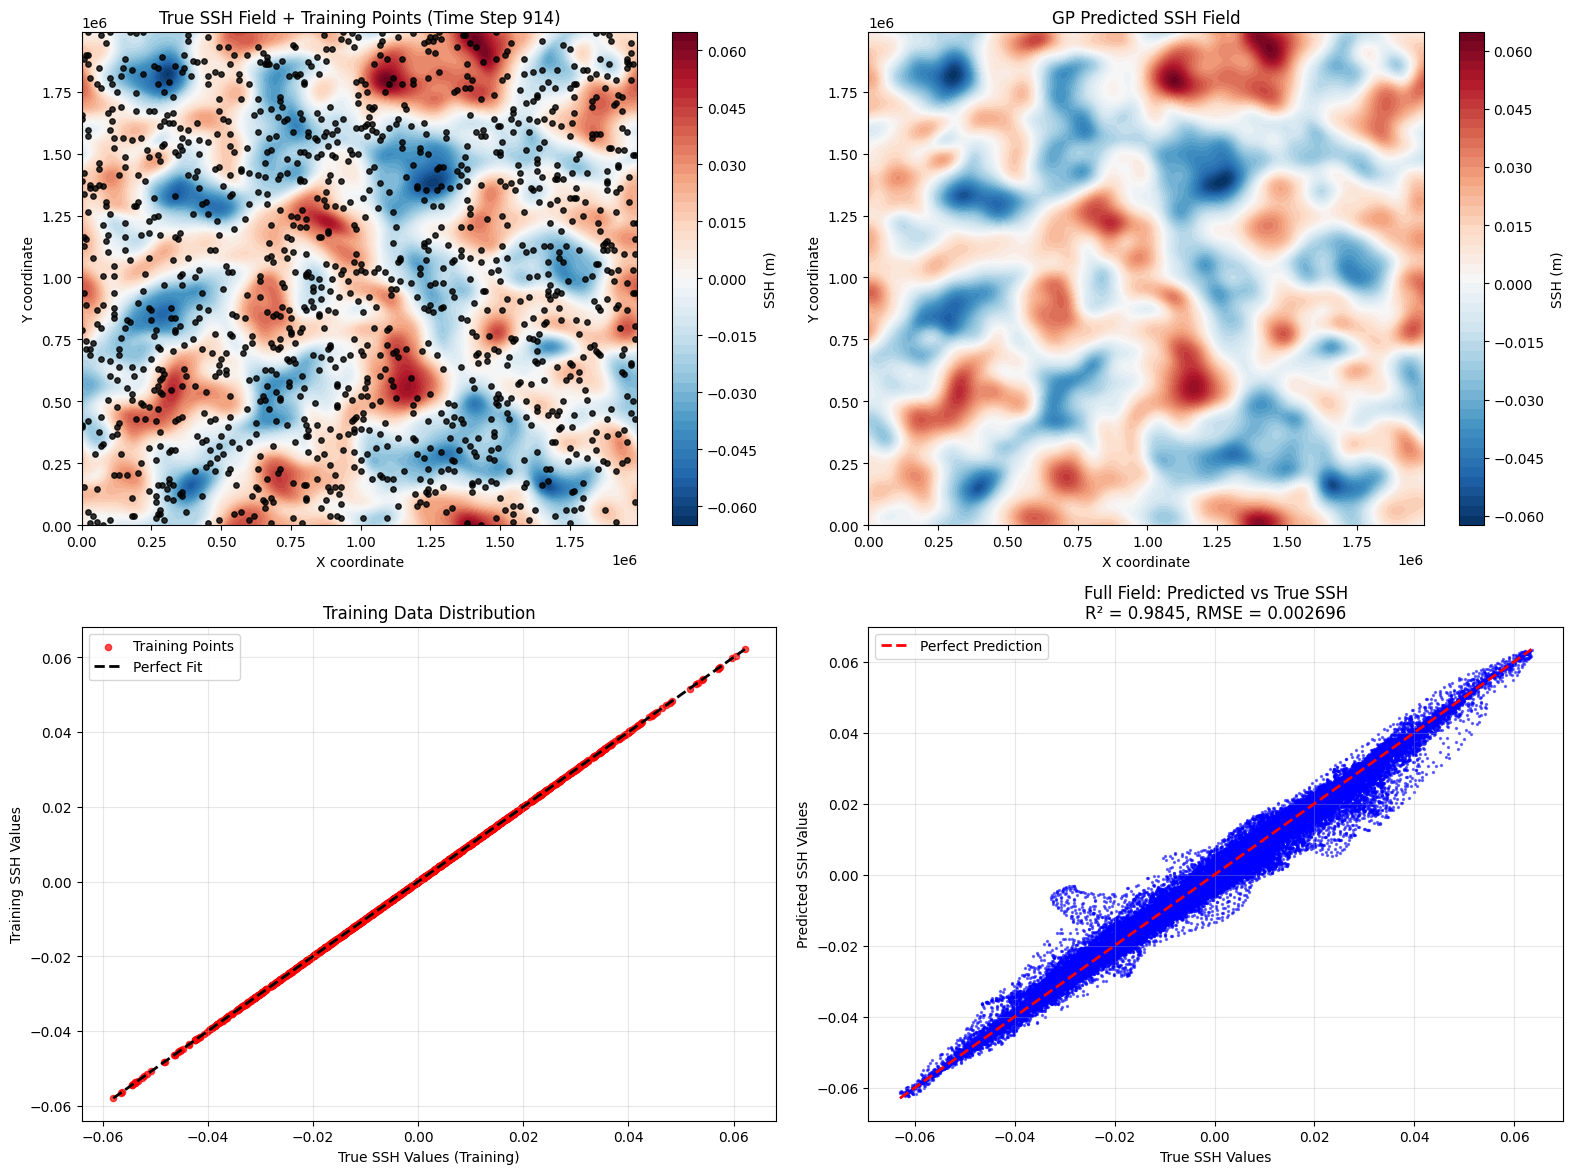


Sample Time Step 914 Statistics:
Training points: 1310
True SSH range: -0.062988 to 0.063484
Training SSH range: -0.057986 to 0.062141
Full field prediction R²: 0.984456
Full field prediction RMSE: 0.002696


In [20]:
# Create Training vs True SSH Visualization
sample_time_idx = time_indices[250]  # Middle time step for visualization
print(f"Creating training vs true SSH plot for time step {sample_time_idx}")

# Get SSH data for sample time step
ssh_slice_sample = ssh_data[sample_time_idx].values
ssh_flat_sample = ssh_slice_sample.flatten()
valid_mask_sample = ~np.isnan(ssh_flat_sample)
X_coords_2d_sample = np.column_stack([X_flat[valid_mask_sample], Y_flat[valid_mask_sample]])
ssh_values_sample = ssh_flat_sample[valid_mask_sample]

# Create training set for this sample
n_total_sample = len(X_coords_2d_sample)
n_train_sample = int(n_total_sample * sampling_ratio)
np.random.seed(42 + sample_time_idx)
train_indices_sample = np.random.choice(n_total_sample, n_train_sample, replace=False)
X_train_sample = X_coords_2d_sample[train_indices_sample]
y_train_sample = ssh_values_sample[train_indices_sample]

# Fit GP for this sample to get predictions
gp_sample = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=1e-6)
gp_sample.fit(X_train_sample, y_train_sample)
y_pred_full_sample = gp_sample.predict(X_coords_2d_sample)

# Reshape for plotting
nx, ny = len(x_coords), len(y_coords)
y_pred_2d = np.full((ny, nx), np.nan)
y_true_2d = ssh_slice_sample

# Fill prediction grid
for i, (x_coord, y_coord) in enumerate(X_coords_2d_sample):
    x_idx = np.argmin(np.abs(x_coords - x_coord))
    y_idx = np.argmin(np.abs(y_coords - y_coord))
    y_pred_2d[y_idx, x_idx] = y_pred_full_sample[i]

# Create comprehensive training vs true SSH visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: True SSH field
im1 = axes[0,0].contourf(x_coords, y_coords, y_true_2d, levels=50, cmap='RdBu_r')
axes[0,0].scatter(X_train_sample[:,0], X_train_sample[:,1], c='black', s=15, alpha=0.8)
axes[0,0].set_title(f'True SSH Field + Training Points (Time Step {sample_time_idx})')
axes[0,0].set_xlabel('X coordinate')
axes[0,0].set_ylabel('Y coordinate')
plt.colorbar(im1, ax=axes[0,0], label='SSH (m)')

# Plot 2: GP Predicted SSH field
im2 = axes[0,1].contourf(x_coords, y_coords, y_pred_2d, levels=50, cmap='RdBu_r')
axes[0,1].set_title('GP Predicted SSH Field')
axes[0,1].set_xlabel('X coordinate')
axes[0,1].set_ylabel('Y coordinate')
plt.colorbar(im2, ax=axes[0,1], label='SSH (m)')

# Plot 3: Training Data vs True SSH Scatter Plot
axes[1,0].scatter(y_train_sample, y_train_sample, c='red', alpha=0.7, s=20, label='Training Points')
axes[1,0].plot([y_train_sample.min(), y_train_sample.max()], 
               [y_train_sample.min(), y_train_sample.max()], 'k--', lw=2, label='Perfect Fit')
axes[1,0].set_xlabel('True SSH Values (Training)')
axes[1,0].set_ylabel('Training SSH Values')
axes[1,0].set_title('Training Data Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Calculate R² and error for full prediction
valid_both = ~(np.isnan(y_true_2d.flatten()) | np.isnan(y_pred_2d.flatten()))
y_true_valid = y_true_2d.flatten()[valid_both]
y_pred_valid = y_pred_2d.flatten()[valid_both]
r2_full = r2_score(y_true_valid, y_pred_valid)
rmse_full = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))

# Plot 4: Full Field Prediction vs True SSH
axes[1,1].scatter(y_true_valid, y_pred_valid, alpha=0.5, s=2, c='blue')
axes[1,1].plot([y_true_valid.min(), y_true_valid.max()], 
               [y_true_valid.min(), y_true_valid.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1,1].set_xlabel('True SSH Values')
axes[1,1].set_ylabel('Predicted SSH Values')
axes[1,1].set_title(f'Full Field: Predicted vs True SSH\nR² = {r2_full:.4f}, RMSE = {rmse_full:.6f}')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics for this sample
print(f"\nSample Time Step {sample_time_idx} Statistics:")
print(f"Training points: {len(y_train_sample)}")
print(f"True SSH range: {np.min(ssh_values_sample):.6f} to {np.max(ssh_values_sample):.6f}")
print(f"Training SSH range: {np.min(y_train_sample):.6f} to {np.max(y_train_sample):.6f}")
print(f"Full field prediction R²: {r2_full:.6f}")
print(f"Full field prediction RMSE: {rmse_full:.6f}")

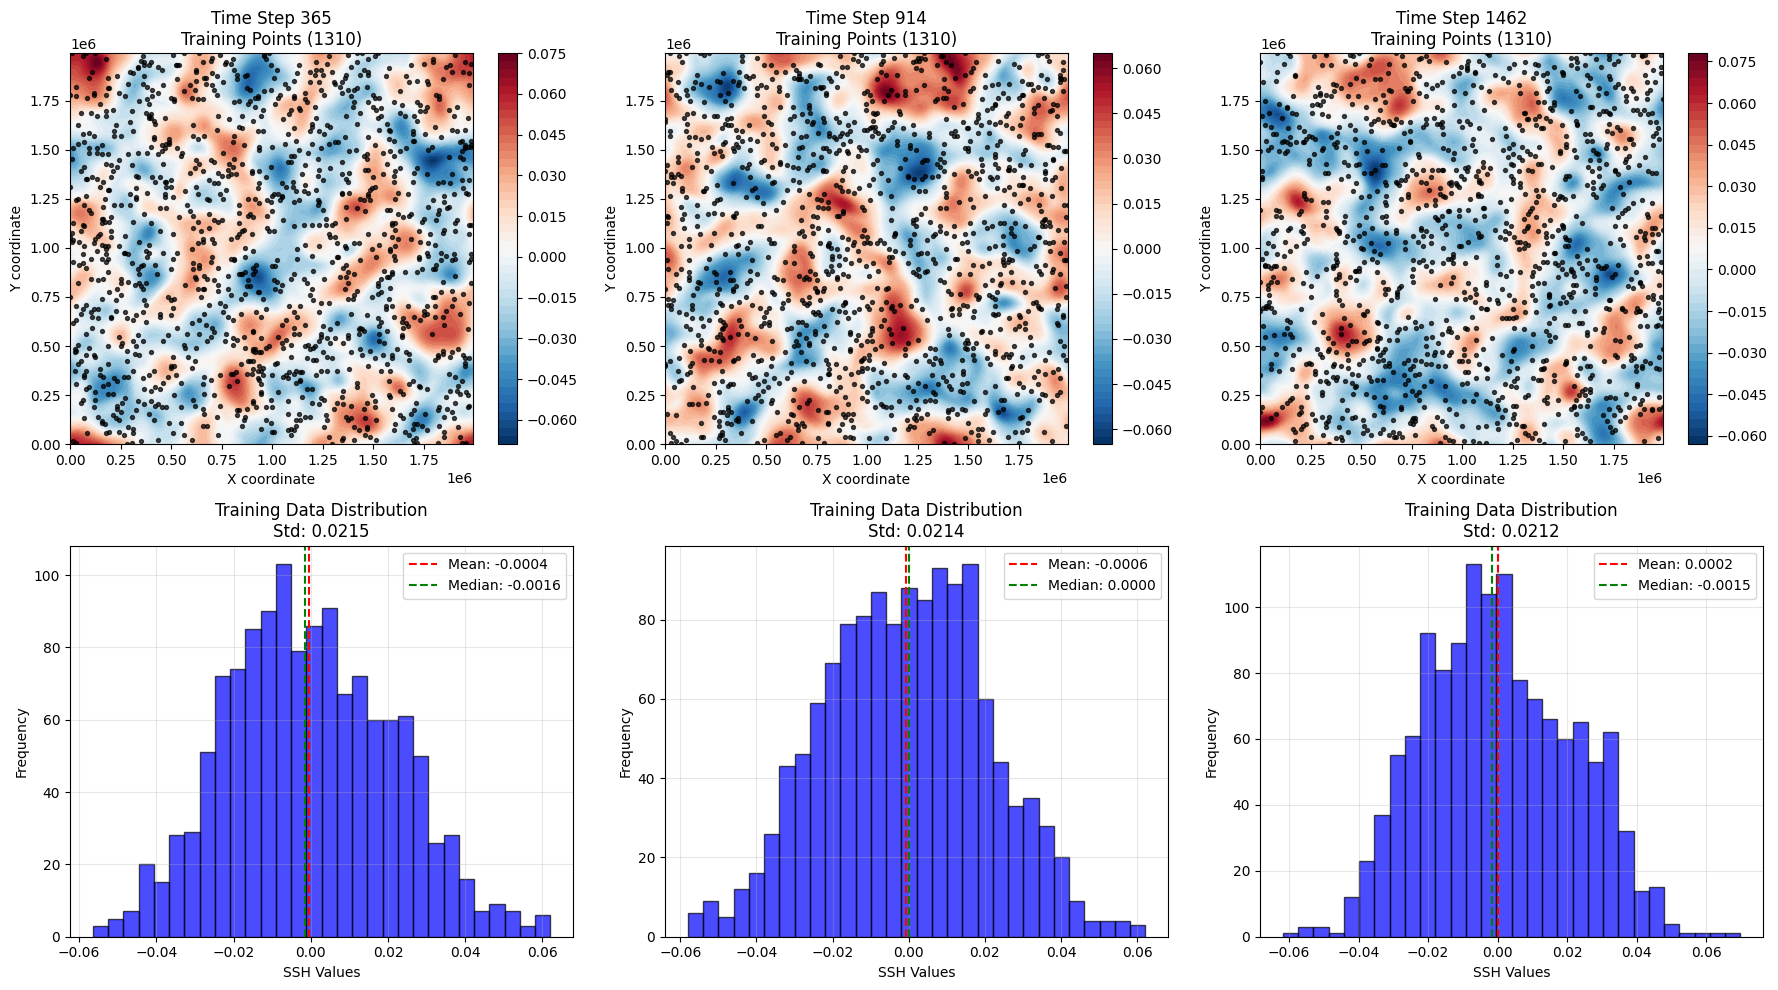

In [21]:
# Detailed Training vs True SSH Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Use the same sample time step
sample_indices = [100, 250, 400]  # Beginning, middle, end of processed time steps

for idx, plot_idx in enumerate(sample_indices):
    time_step = time_indices[plot_idx]
    
    # Get data for this time step
    ssh_slice = ssh_data[time_step].values
    ssh_flat = ssh_slice.flatten()
    valid_mask = ~np.isnan(ssh_flat)
    X_coords_2d = np.column_stack([X_flat[valid_mask], Y_flat[valid_mask]])
    ssh_values = ssh_flat[valid_mask]
    
    # Create training set
    n_total = len(X_coords_2d)
    n_train = int(n_total * sampling_ratio)
    np.random.seed(42 + time_step)
    train_indices = np.random.choice(n_total, n_train, replace=False)
    X_train = X_coords_2d[train_indices]
    y_train = ssh_values[train_indices]
    
    # Top row: SSH fields with training points
    im = axes[0,idx].contourf(x_coords, y_coords, ssh_slice, levels=50, cmap='RdBu_r')
    axes[0,idx].scatter(X_train[:,0], X_train[:,1], c='black', s=8, alpha=0.7)
    axes[0,idx].set_title(f'Time Step {time_step}\nTraining Points ({len(X_train)})')
    axes[0,idx].set_xlabel('X coordinate')
    axes[0,idx].set_ylabel('Y coordinate')
    plt.colorbar(im, ax=axes[0,idx])
    
    # Bottom row: Training data histograms
    axes[1,idx].hist(y_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[1,idx].axvline(x=np.mean(y_train), color='red', linestyle='--', 
                        label=f'Mean: {np.mean(y_train):.4f}')
    axes[1,idx].axvline(x=np.median(y_train), color='green', linestyle='--', 
                        label=f'Median: {np.median(y_train):.4f}')
    axes[1,idx].set_xlabel('SSH Values')
    axes[1,idx].set_ylabel('Frequency')
    axes[1,idx].set_title(f'Training Data Distribution\nStd: {np.std(y_train):.4f}')
    axes[1,idx].legend()
    axes[1,idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

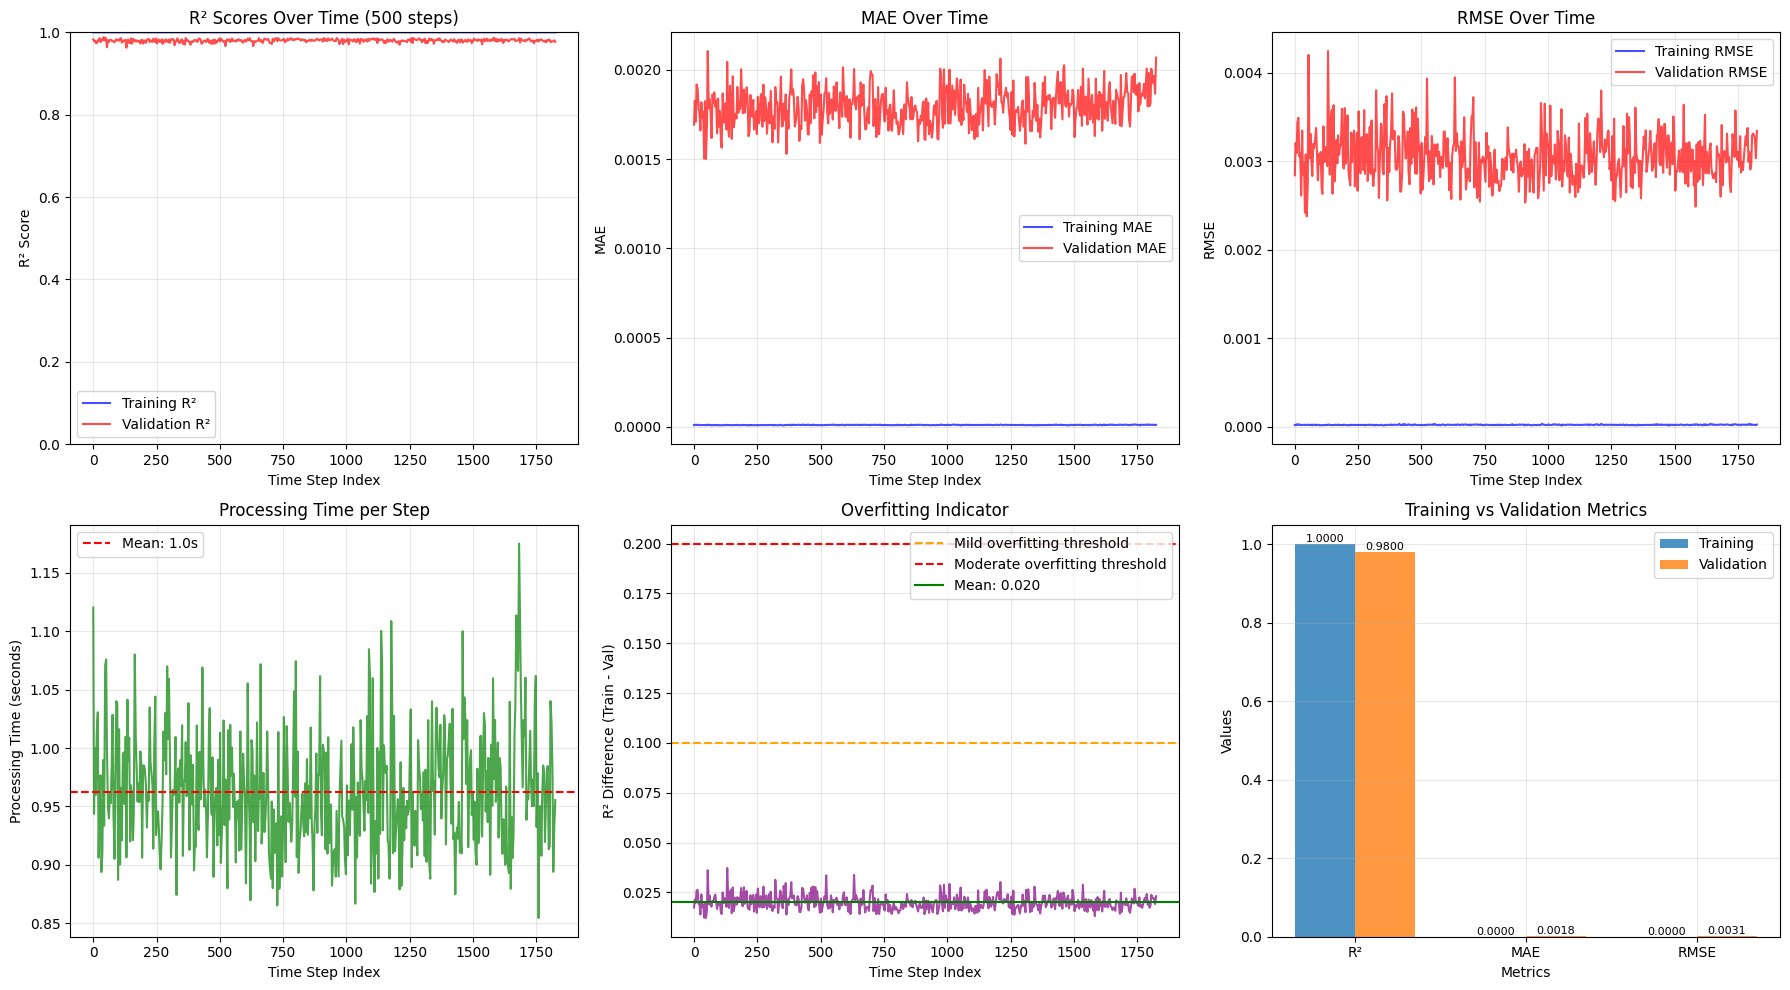

In [19]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: R² scores over time
axes[0,0].plot(time_indices_processed, train_r2_scores, 'b-', label='Training R²', alpha=0.7, linewidth=1.5)
axes[0,0].plot(time_indices_processed, val_r2_scores, 'r-', label='Validation R²', alpha=0.7, linewidth=1.5)
axes[0,0].set_xlabel('Time Step Index')
axes[0,0].set_ylabel('R² Score')
axes[0,0].set_title('R² Scores Over Time (500 steps)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_ylim([0, 1])

# Plot 2: MAE scores over time
axes[0,1].plot(time_indices_processed, train_mae_scores, 'b-', label='Training MAE', alpha=0.7, linewidth=1.5)
axes[0,1].plot(time_indices_processed, val_mae_scores, 'r-', label='Validation MAE', alpha=0.7, linewidth=1.5)
axes[0,1].set_xlabel('Time Step Index')
axes[0,1].set_ylabel('MAE')
axes[0,1].set_title('MAE Over Time')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: RMSE scores over time
axes[0,2].plot(time_indices_processed, train_rmse_scores, 'b-', label='Training RMSE', alpha=0.7, linewidth=1.5)
axes[0,2].plot(time_indices_processed, val_rmse_scores, 'r-', label='Validation RMSE', alpha=0.7, linewidth=1.5)
axes[0,2].set_xlabel('Time Step Index')
axes[0,2].set_ylabel('RMSE')
axes[0,2].set_title('RMSE Over Time')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Processing time per step
axes[1,0].plot(time_indices_processed, processing_times, 'g-', alpha=0.7, linewidth=1.5)
axes[1,0].axhline(y=np.mean(processing_times), color='r', linestyle='--', 
                  label=f'Mean: {np.mean(processing_times):.1f}s')
axes[1,0].set_xlabel('Time Step Index')
axes[1,0].set_ylabel('Processing Time (seconds)')
axes[1,0].set_title('Processing Time per Step')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 5: R² difference (overfitting indicator)
axes[1,1].plot(time_indices_processed, r2_differences, 'purple', alpha=0.7, linewidth=1.5)
axes[1,1].axhline(y=0.1, color='orange', linestyle='--', label='Mild overfitting threshold')
axes[1,1].axhline(y=0.2, color='red', linestyle='--', label='Moderate overfitting threshold')
axes[1,1].axhline(y=np.mean(r2_differences), color='green', linestyle='-', 
                  label=f'Mean: {np.mean(r2_differences):.3f}')
axes[1,1].set_xlabel('Time Step Index')
axes[1,1].set_ylabel('R² Difference (Train - Val)')
axes[1,1].set_title('Overfitting Indicator')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Performance comparison bar chart
metrics = ['R²', 'MAE', 'RMSE']
train_metrics = [np.mean(train_r2_scores), np.mean(train_mae_scores), np.mean(train_rmse_scores)]
val_metrics = [np.mean(val_r2_scores), np.mean(val_mae_scores), np.mean(val_rmse_scores)]

x_pos = np.arange(len(metrics))
width = 0.35

bars1 = axes[1,2].bar(x_pos - width/2, train_metrics, width, label='Training', alpha=0.8)
bars2 = axes[1,2].bar(x_pos + width/2, val_metrics, width, label='Validation', alpha=0.8)

axes[1,2].set_xlabel('Metrics')
axes[1,2].set_ylabel('Values')
axes[1,2].set_title('Training vs Validation Metrics')
axes[1,2].set_xticks(x_pos)
axes[1,2].set_xticklabels(metrics)
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()